In [1]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
import sounddevice as sd
from scipy.signal import get_window

from util import my_windowing, compute_istft

%matplotlib widget

Download the file Exercise6.zip from Moodle which contains two speech signals which are corrupted once by white noise and once by babble noise. For both files the signal-to-noise ratio (SNR) is 10 dB.

In [2]:
class WaveFile:
    filename: str
    y: np.ndarray
    sr: int
    num_samples: int

    def __init__(self, filename: str) -> None:
        self.filename = filename
        self.y, self.sr = librosa.load(filename, sr=None)

    def play(self):
         sd.play(self.y, self.sr)

    def _split_frames(self, frame_length, frame_shift):
        self.m_frames, self.v_time = my_windowing(
            self.y,
            self.sr,
            frame_length,
            frame_shift
        )
        self.num_frames = self.m_frames.shape[0]
        self.samples_per_frame = self.m_frames.shape[1]
    
    def compute_stft(self, frame_length: int, frame_shift: int, window: str):
        self._split_frames(frame_length, frame_shift)
        
        v_analysis_window = np.sqrt(get_window(window=window, Nx=self.samples_per_frame, fftbins=True))

        # create frequency vector
        v_freq = self.sr * (np.arange(self.samples_per_frame / 2 + 1) / self.samples_per_frame)

        # calculate DFT
        _m_frames = self.m_frames
        _m_frames *= v_analysis_window
        dft = np.fft.fft(_m_frames, axis=1)

        # drop upper half of the spectrum while keeping the nyquist frequency in the middle
        num_freq_bins = dft.shape[1]
        if num_freq_bins % 2 == 0: # even 
            dft = dft[:, : num_freq_bins // 2 + 1]
        else: # odd
            dft = dft[:, : (num_freq_bins + 1) // 2]
        m_stft = dft
        
        np.testing.assert_array_almost_equal(m_stft, np.fft.rfft(_m_frames, axis=1))
        
        self.m_stft = m_stft.T
        self.v_freq = v_freq

    def set_spp(self, m_spp: np.ndarray):
        self.m_spp = m_spp
    
    def set_psd(self, m_signal_psd:np.ndarray, m_noise_psd: np.ndarray):
        self.m_signal_psd = m_signal_psd
        self.m_noise_psd = m_noise_psd

    def set_enhanced_stft(self, m_enhanced_stft: np.ndarray):
        self.m_enhanced_stft = m_enhanced_stft


speech_babble = WaveFile("SpeechBabble.wav")
speech_white = WaveFile("SpeechWhite.wav")

frame_length = 32
frame_shift = 16

speech_babble.compute_stft(frame_length, frame_shift, "hann")
speech_white.compute_stft(frame_length, frame_shift, "hann")

In [ ]:
speech_babble.play()

In [ ]:
speech_white.play()

**Acronyms**

- STFT - Short-time Fourier-Transformation
- PSD - Power Spectral Density
- SPP - Speech Presence Probability


**1 Noise Power Estimation**

In this part of the exercise, the noise power is estimated based on the speech presence probability. First, use
your functions from the second exercise to create the STFT of the noisy input signals. The frame length should
be 32 ms and the frame shift 16 ms. Use a √Hann-window as analysis window. From the STFT, compute the
periodograms and determine the noise PSD by performing the following steps for each frame.

1. Compute the posterior probability of speech presence
2. Avoid stagnations by smoo

- Signal-to-noise ratio (SNR): $\theta = 15 \ dB$

In [3]:
def compute_ssp(f: WaveFile, snr: int):
    m_signal_psd = np.abs(f.m_stft)**2
    num_frames = m_signal_psd.shape[0]
    num_bins = m_signal_psd.shape[1]
    
    m_spp = np.zeros((num_frames, num_bins))
    m_noise_psd = np.zeros((num_frames, num_bins+1))
    Q = np.zeros((num_frames, num_bins+1))

    # init noise periodogram
    m_noise_psd[:, 0] = np.abs(f.m_stft[:, 0])**2

    # loop over frequency bins
    for i in range(num_bins):
        # speech presence probability (1)
        m_spp[:, i] = (1 + (1 + snr) * np.exp(-(m_signal_psd[:, i] / m_noise_psd[:, i]) * (snr / (1 + snr))))**(-1)

        # smoothed posterior probability Q (2)
        Q[:, i+1] = 0.9 * Q[:, i] + 0.1 * m_spp[:, i]
        # set computed posterior probability for each frequency bin
        for j in range(num_frames):
            if Q[j, i+1] > 0.99:
                m_spp[j, i] = min(m_spp[j, i], 0.99)

        # estimate the noise periodogram (3)
        noise_periodogram = m_spp[:, i] * m_noise_psd[:, i] + (1 - m_spp[:, i]) * m_signal_psd[:, i]
        
        # update noise power density (4)
        m_noise_psd[:, i+1] = 0.8 * m_noise_psd[:, i] + 0.2*noise_periodogram

    f.set_spp(m_spp)
    f.set_psd(m_signal_psd, m_noise_psd)

compute_ssp(speech_babble, 15)
compute_ssp(speech_white, 15)

**Questions**

1.1 In equation (1), (3) and (4) the noise power estimate from the previous frame, $\hat\sigma^2_n[k, \ell-1]$, is required. However, there is none available for the first frame $\ell=0$. The same problem occurs for the smoothed speech presence probability $Q[k,\ell]$ in (2).

a) What would be appropriate initializations for the first noise estimate $\hat\sigma^2_n[k, \ell-1]$ and the smoothed posterior probability $Q[k,\ell−1]$? Explain briefly why you chose your initialization method.

1.2 Plot the speech presence probability $P(H_1|Y[k,\ell])$ using `plt.imshow`.

a) Which values do you obtain for time-frequency points where speech is present?

b) What values do you get for time-frequency points where only noise is present?

c) If you compare the speech presence probability with the spectrogram of your input signal, can you see
similarities?

1.3 Plot the estimated noise PSD as a spectrogram using plt.imshow.

a) How well is the background noise estimated?

b) Can you observe errors (e. g. components that do not belong to the background noise)?

c) What would be the consequence of such errors?

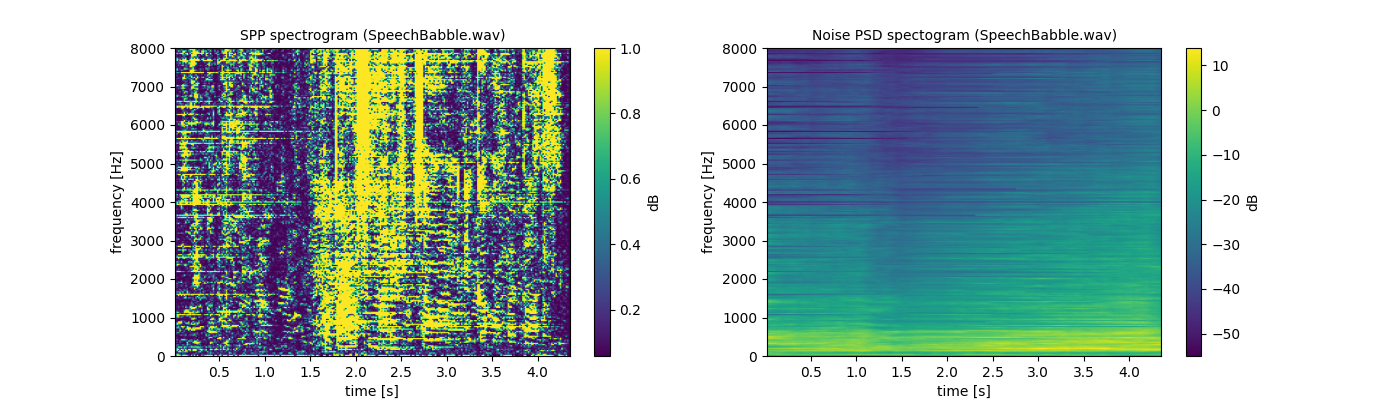

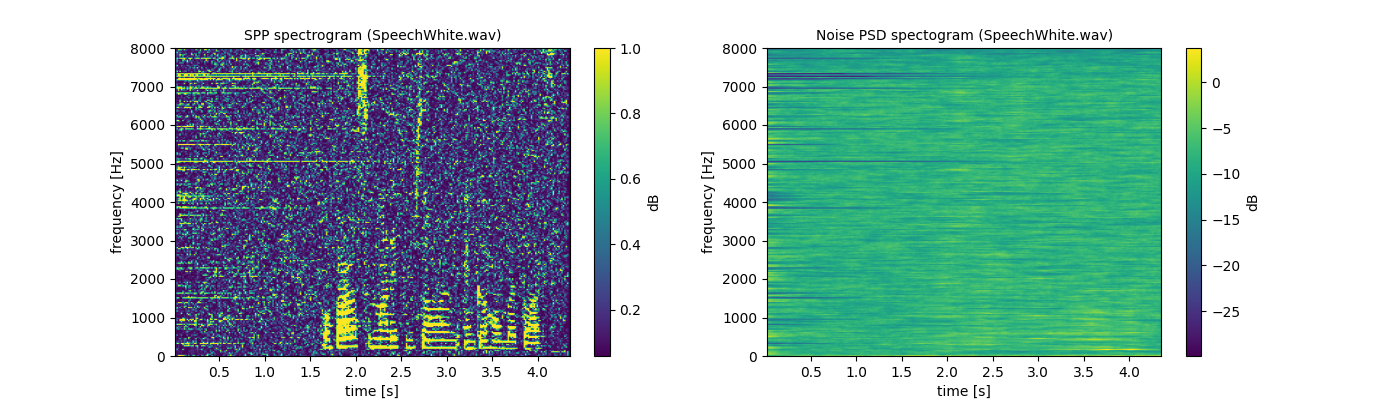

In [4]:
def plot_ssp_spectorgram(f: WaveFile):
    fig, axes = plt.subplots(1, 2, figsize=(14,4))
    axes = axes.flatten()
    
    ax = axes[0]
    ax.set_title(f"SPP spectrogram ({f.filename})", fontdict={"size": 10})
    ax.set_xlabel("time [s]")
    ax.set_ylabel("frequency [Hz]")
    im = ax.imshow(
        f.m_spp,
        extent=[f.v_time[0], f.v_time[-1], f.v_freq[0], f.v_freq[-1]],
        origin="lower",
        aspect="auto",
    )
    colorbar = fig.colorbar(im, orientation="vertical")
    colorbar.set_label("dB")

    ax = axes[1]
    ax.set_title(f"Noise PSD spectogram ({f.filename})", fontdict={"size": 10})
    ax.set_xlabel("time [s]")
    ax.set_ylabel("frequency [Hz]")
    im = ax.imshow(
        10*np.log10(f.m_noise_psd),
        extent=[f.v_time[0], f.v_time[-1], f.v_freq[0], f.v_freq[-1]],
        origin="lower",
        aspect="auto",
    )
    colorbar = fig.colorbar(im, orientation="vertical")
    colorbar.set_label("dB")

plot_ssp_spectorgram(speech_babble)
plot_ssp_spectorgram(speech_white)

**2 A priori SNR estimation and Wiener Filtering**

In this part of the exercise, we will obtain an estimate of the a priori SNR $\hat\xi$ from our noise power estimate
$\hat\sigma^2_n[k, \ell]$ using the decision-directed approach. It is given by (5):
$$
\hat\xi[k,\ell] = \alpha\frac{|\hat S[k,\ell-1]|^2}{\hat\sigma^2_n[k,\ell]} + (1-\alpha) max(\frac{|Y[k,\ell]|^2}{\hat\sigma^2_n[k,\ell]}-1, 0)
$$

Here, $\hat S$ denotes the estimate of the clean speech spectrum $S$. The gain function $G$ of the Wiener-Filter is (6):
$$
G[k,\ell] = max(\frac{\hat\xi[k,\ell]}{1+\hat\xi[k,\ell]}, G_{min})
$$

The enhanced spectra are finally obtained via (7):
$$
\hat S[k,\ell] = G[k,\ell] Y[k,\ell]
$$

Perform the steps in equations (5) – (7) for every frame of your input signal and store all enhanced speech spectra $\hat S[k,\ell]$ in a matrix, e.g. `m_enhanced_stft`.

In [5]:
def a_priori_snr(f: WaveFile, snr: int, alpha: float, g_min: float) -> np.ndarray:
    num_frames = f.m_stft.shape[0]
    num_bins = f.m_stft.shape[1]

    xi = np.zeros((num_frames, num_bins), dtype="complex_")
    gain = np.zeros((num_frames, num_bins), dtype="complex_")
    m_enhanced_stft = np.zeros((num_frames, num_bins+1), dtype="complex_")

    # loop over frequency bins
    for i in range(num_bins):
        # a priori SNR estimate (5)
        xi[:, i] = alpha * m_enhanced_stft[:, i] / f.m_noise_psd[:, i]  + (1 - alpha) * np.fmax(f.m_signal_psd[:, i] / f.m_noise_psd[:, i] - 1, 0)
        
        # gain function G of the Wiener-Filter (6)
        gain[:, i] = np.maximum(xi[:, i] / (1 + xi[:, i]), g_min)

        # enhanced speech spectra (7)
        m_enhanced_stft[:, i+1] = f.m_stft[:, i] * gain[:, i]
    
    return m_enhanced_stft

speech_babble.set_enhanced_stft(a_priori_snr(speech_babble, 15, 0.5, 0))
speech_white.set_enhanced_stft(a_priori_snr(speech_white, 15, 0.5, 0))

*Questions*

2.1 In equation (5), the issue from Section 1 occurs again. An initialization for $\hat S[k, \ell]$ is required for the first
frame.

*What would be a reasonable choice in this case?*

2.2 Set $\alpha = 0.5$ and $G_{min} = 0$. Plot the magnitude spectrogram of the noisy speech signal and the enhanced speech signal in dB and compare both. Make sure, that the color bar for both plots is the same. This can be achieved by manually setting the `vmin` and `vmax` parameters of `plt.imshow`.

a) How does the clean spectrogram differ from the spectrogram of the noisy input signal?

b) Can you see artifacts in the spectrogram of the enhanced signal?

**3 Parameter tuning**

Use the compute_istft function to synthesize the enhanced speech signal. For this, employ the same frame shift
and FFT length as in Section 1. Further, use the √Hann-window also for the synthesis.

Listen to the noisy signal and the enhanced signal. For this you could use the play function from sounddevice.

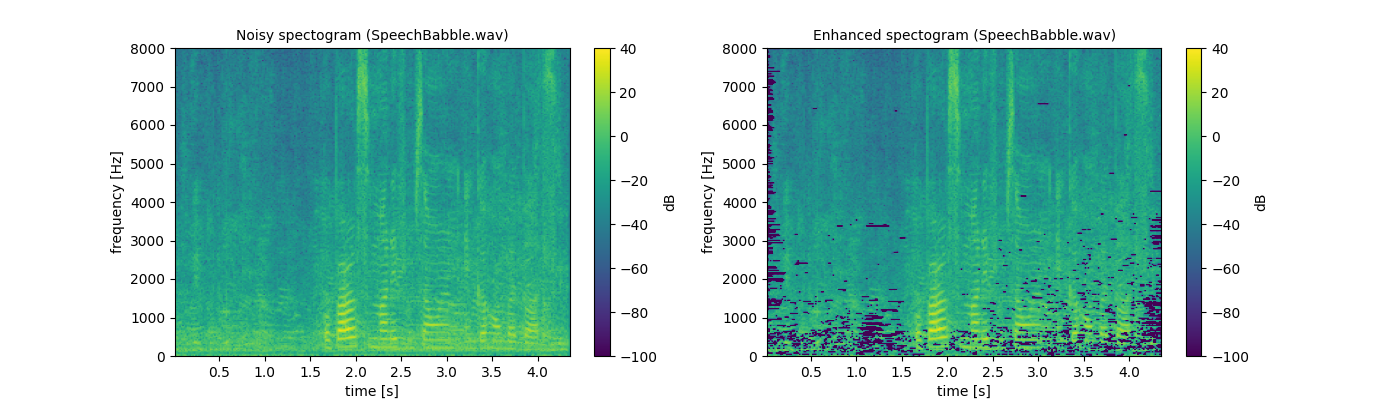

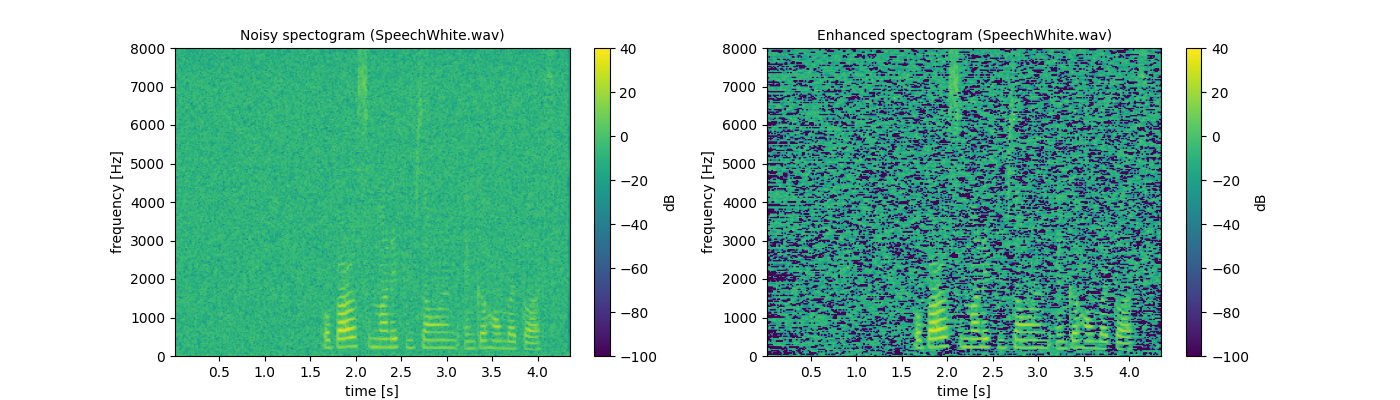

In [6]:
def plot_enhanced_spectogram(f: WaveFile):
    fig, axes = plt.subplots(1, 2, figsize=(14,4))
    axes = axes.flatten()

    vmin = -100
    vmax = 40
    
    ax = axes[0]
    ax.set_title(f"Noisy spectogram ({f.filename})", fontdict={"size": 10})
    ax.set_xlabel("time [s]")
    ax.set_ylabel("frequency [Hz]")
    im = ax.imshow(
        10*np.log10(np.fmax(np.abs(f.m_stft)**2, 10**-15)),
        extent=[f.v_time[0], f.v_time[-1], f.v_freq[0], f.v_freq[-1]],
        origin="lower",
        aspect="auto",
        vmin=vmin, 
        vmax=vmax,
    )
    colorbar = fig.colorbar(im, orientation="vertical")
    colorbar.set_label("dB")

    ax = axes[1]
    ax.set_title(f"Enhanced spectogram ({f.filename})", fontdict={"size": 10})
    ax.set_xlabel("time [s]")
    ax.set_ylabel("frequency [Hz]")
    im = ax.imshow(
        10*np.log10(np.fmax(np.abs(f.m_enhanced_stft[:, 2:]**2), 10**-15)),
        extent=[f.v_time[0], f.v_time[-1], f.v_freq[0], f.v_freq[-1]],
        origin="lower",
        aspect="auto",
        vmin=vmin, 
        vmax=vmax,
    )
    colorbar = fig.colorbar(im, orientation="vertical")
    colorbar.set_label("dB")

plot_enhanced_spectogram(speech_babble)
plot_enhanced_spectogram(speech_white)

Use the `compute_istft` function to synthesize the enhanced speech signal. For this, employ the same frame shift and FFT length as in Section 1. Further, use the $\sqrt{Hann}$-window also for the synthesis.
<!--  -->
Listen to the noisy signal and the enhanced signal.

In [7]:
hann_window = np.sqrt(get_window("hann", speech_babble.samples_per_frame, True))

In [ ]:
g_min = 0
alpha = 0.9

speech_babble.set_enhanced_stft(a_priori_snr(speech_babble, 15, 0, g_min))
speech_babble_enhanced = compute_istft(speech_babble.m_enhanced_stft[:, 2:], speech_babble.sr, frame_shift, hann_window)

# sd.play(speech_babble.y, speech_babble.sr, blocking=True)
# sd.play(speech_babble.y, speech_babble.sr, blocking=True)
sd.play(speech_babble_enhanced, speech_babble.sr, blocking=True)

speech_babble.set_enhanced_stft(a_priori_snr(speech_babble, 15, 0.9, g_min))
speech_babble_enhanced = compute_istft(speech_babble.m_enhanced_stft.T[:, 2:], speech_babble.sr, frame_shift, hann_window)
sd.play(speech_babble_enhanced, speech_babble.sr, blocking=True)

In [ ]:
g_min = 0
alpha = 0

speech_white.set_enhanced_stft(a_priori_snr(speech_white, 15, alpha, g_min))
speech_white_enhanced = compute_istft(speech_white.m_enhanced_stft[:, 2:], speech_white.sr, frame_shift, hann_window)

sd.play(speech_white.y, speech_white.sr, blocking=True)
sd.play(speech_white_enhanced, speech_white.sr, blocking=True)

### Questions

**3.1 Compare the noisy and the enhanced signal with each other.**

Parameter values: $\alpha = 0.5$ and $G_{min} = 0$

a) How well is the background noise suppressed?
- okay-ish for the babble noise
- not well at all for the white noise

b) Can you hear any distortions of the speech signal in the enhanced signal?
- yes, primarily in the white noise signal

c) What artifacts can you hear?
- high-pitched noise

**3.2 Vary $\alpha$ between 0 and 1 and listen to the synthesized signals.**

a) What differences can you perceive?
- $\alpha = 0$
    - works well for babble noise
    - fairly minimal enhancement but less artifacts for white noise
- $\alpha = 1$
    - setting $\alpha$ to 1 results in a 0 in equation (5) resulting an empty signal

b) How do the artifacts, speech signal and noise suppression change?

c) What is your favorite setting? Explain why.
    - The optimal value for $\alpha$ depends on the type of noise
    - $\alpha = 0.5$ seems like a sensible choice for both babble and white noise

d) Are the differences you heard also visible in the spectrogram of the enhanced speech signal?

**3.3 Try different values for $G_{min}$ which can be varied between $0$ and $1$, i. e. between $-\infty$ dB and $0$ dB. Listen again to the synthesized signals.**

a) What differences can be perceived now?

b) How does this parameter affect the artifacts, speech signal and noise suppression and what would be your favorite setting this time? Again, explain why.

c) How do the spectrograms change in this case?

In your report, include some spectrograms that support your reasoning for your choice of the parameters $\alpha$ and $G_{min}$.

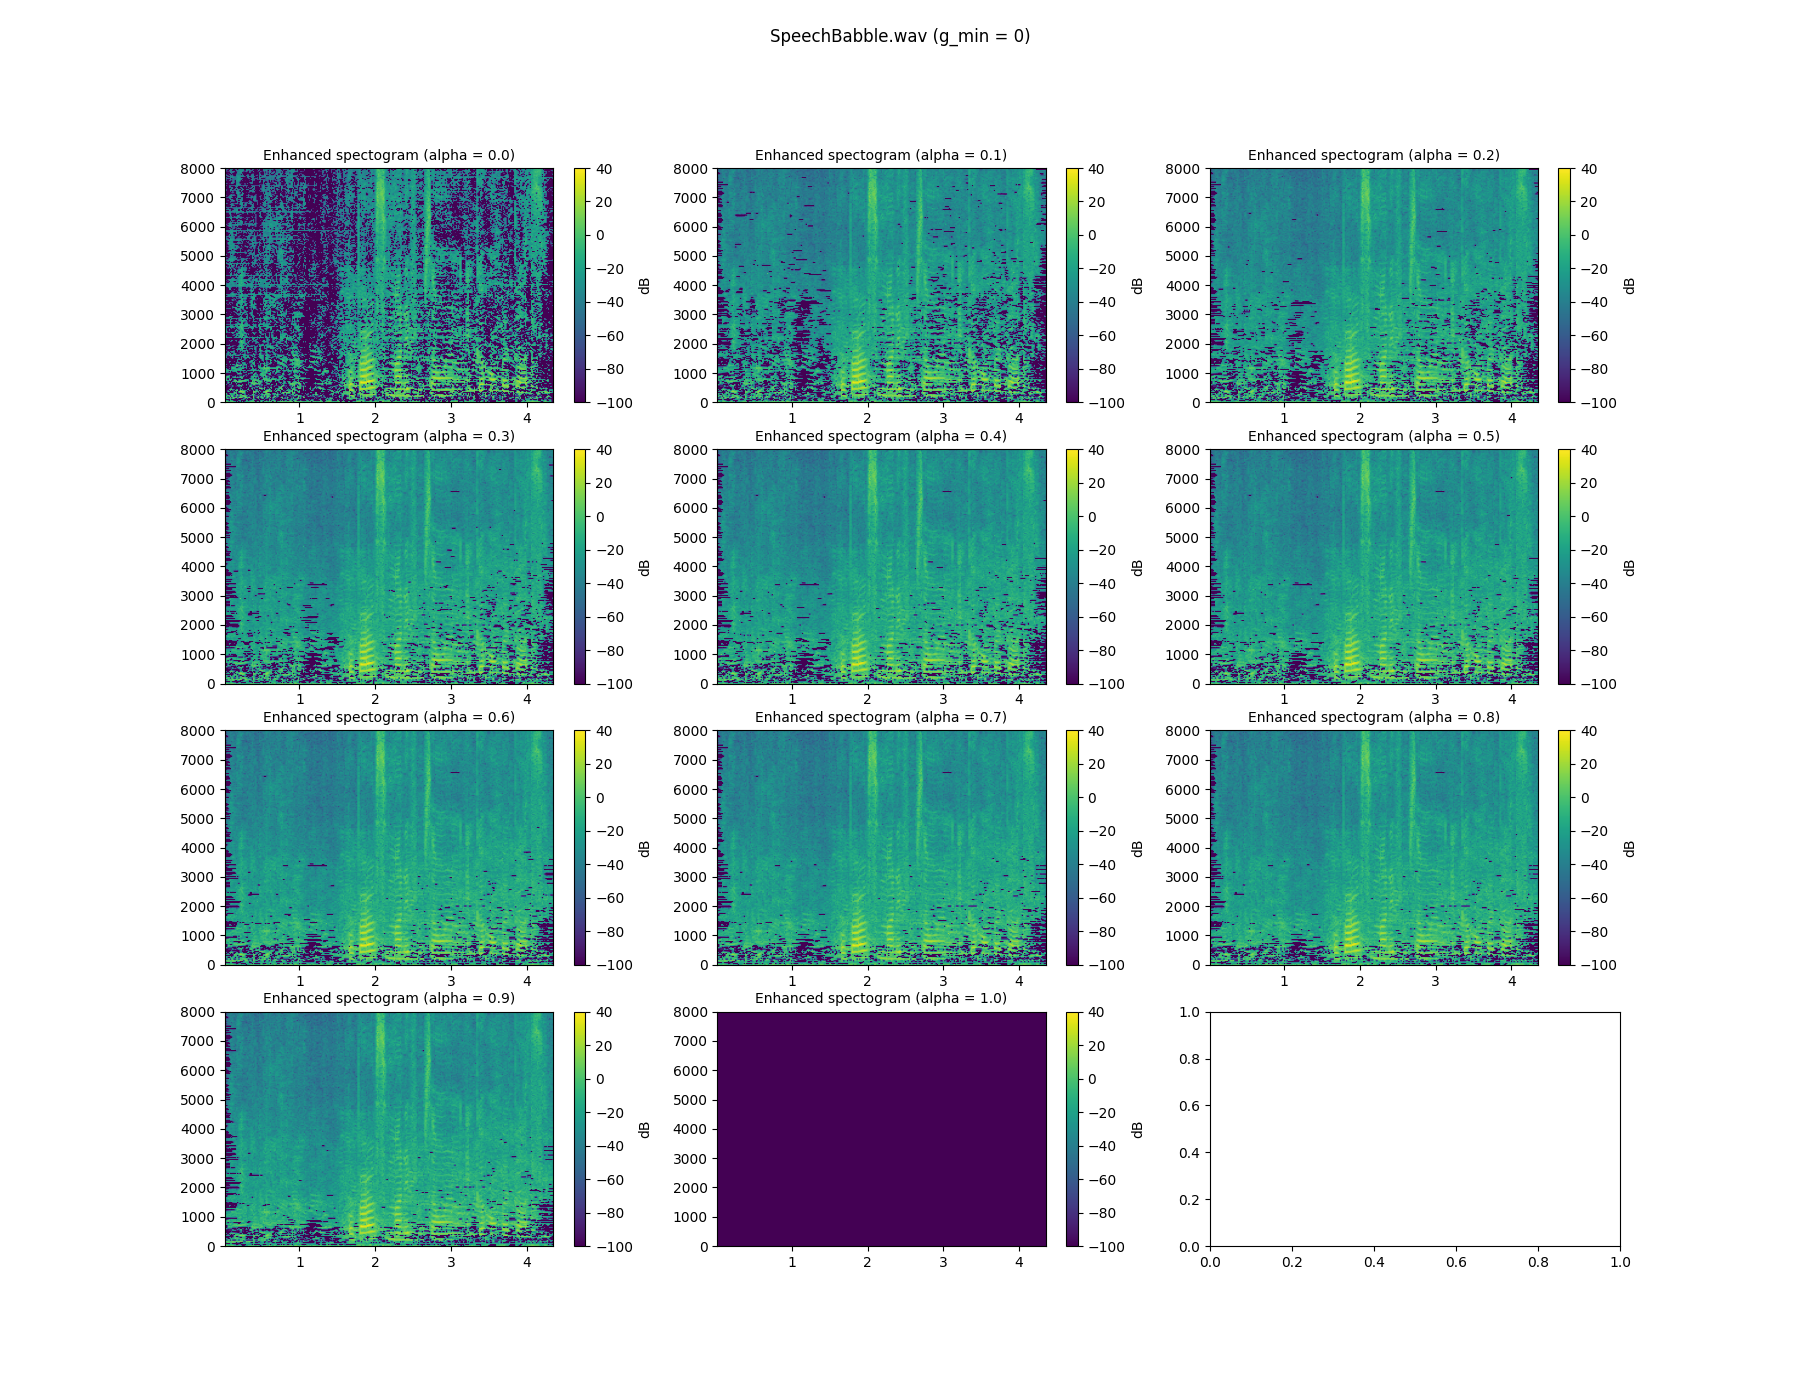

In [9]:
def plot_variable_alpha(f: WaveFile, g_min: float):
    fig, axes = plt.subplots(4, 3, figsize=(18,14))
    fig.suptitle(f"{f.filename} (g_min = {g_min})")
    axes = axes.flatten()

    enhanced_stfts = []
    def on_click(event):
        if not event.inaxes: return
        if str(event.button) != "MouseButton.LEFT": return
        for i, ax in enumerate(axes): 
            if event.inaxes == ax: break
        if len(enhanced_stfts) < i+1: return
        sd.play(compute_istft(enhanced_stfts[i][:, 2:], f.sr, frame_shift, hann_window), f.sr)

    fig.canvas.mpl_connect("button_press_event", on_click)
    
    snr = 10
    vmin = -100
    vmax = 40

    for i in range(len(axes)):
        alpha = i / 10
        if alpha > 1:
            break

        m_enhanced_stft = a_priori_snr(f, snr, alpha, g_min)
        enhanced_stfts.append(m_enhanced_stft)
        ax = axes[i]
        ax.set_title(f"Enhanced spectogram (alpha = {alpha})", fontdict={"size": 10})
 
        im = ax.imshow(
            10*np.log10(np.fmax(np.abs(m_enhanced_stft[:, 2:]**2), 10**-15)),
            extent=[f.v_time[0], f.v_time[-1], f.v_freq[0], f.v_freq[-1]],
            origin="lower",
            aspect="auto",
            vmin=vmin, 
            vmax=vmax,
        )
        colorbar = fig.colorbar(im, orientation="vertical")
        colorbar.set_label("dB")
    
plot_variable_alpha(speech_babble, 0)

In [ ]:
plot_variable_alpha(speech_white, 0)